<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [0]:
import pandas as pd
import numpy as np

In [0]:
# updated daily
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=2, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

In [5]:
time_series_df.head()

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2020-03-13,ABW,Aruba,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-20,ABW,Aruba,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-24,ABW,Aruba,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-25,ABW,Aruba,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-26,ABW,Aruba,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
df_germany = time_series_df[time_series_df['location'] == 'Germany']
df_germany.head()

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-01,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-02,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-03,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,DEU,Germany,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


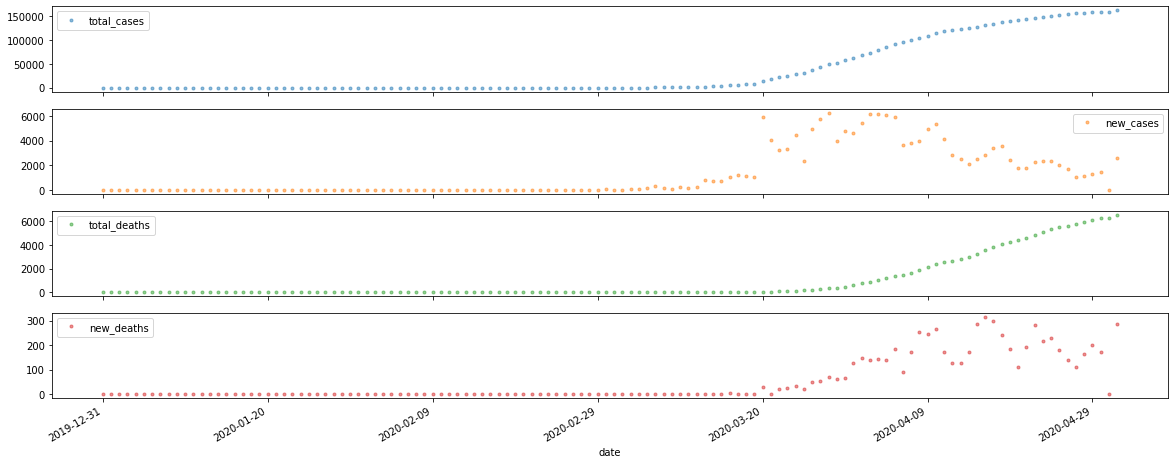

In [7]:
cols_plot = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths']

axes = df_germany[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)

In [0]:
new_deaths_df = df_germany['new_deaths']
total_cases_df = df_germany['total_cases']
new_cases_df = df_germany['new_cases']
total_deaths_df = df_germany['total_deaths']

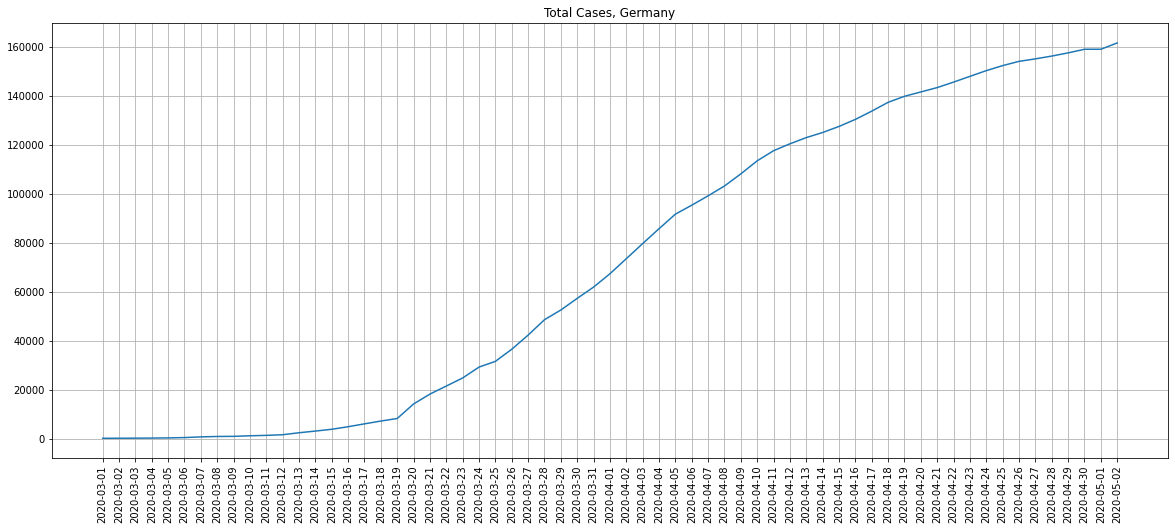

In [9]:
plt.plot(total_cases_df['2020-03-01':])
plt.xticks(rotation=90)
plt.title("Total Cases, Germany")
plt.grid()

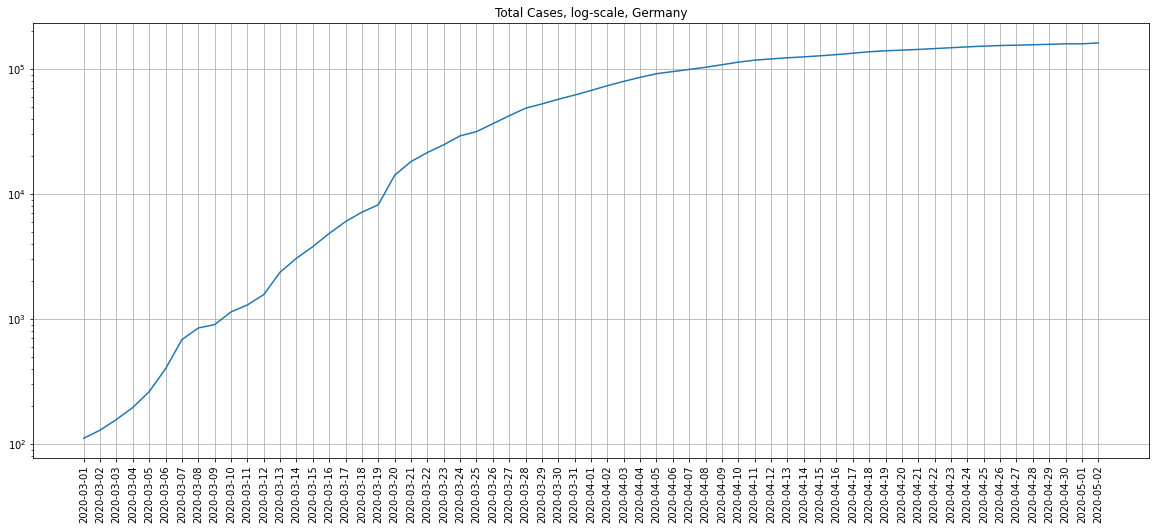

In [10]:
plt.plot(total_cases_df['2020-03-01':])
plt.xticks(rotation=90)
plt.title("Total Cases, log-scale, Germany")
plt.yscale('log')
plt.grid()

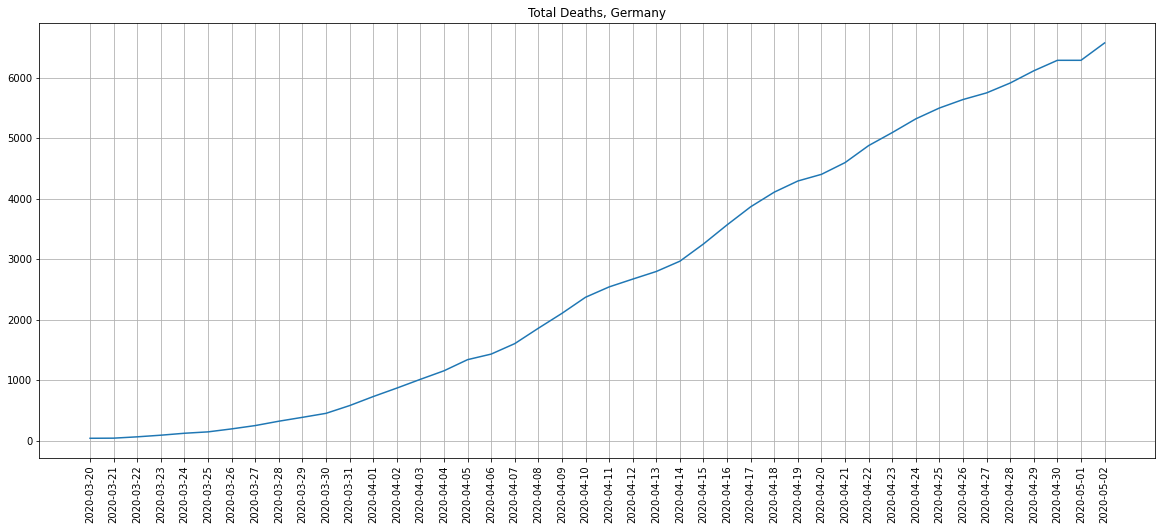

In [11]:
plt.plot(total_deaths_df['2020-03-20':])
plt.xticks(rotation=90)
plt.title("Total Deaths, Germany")
plt.grid()

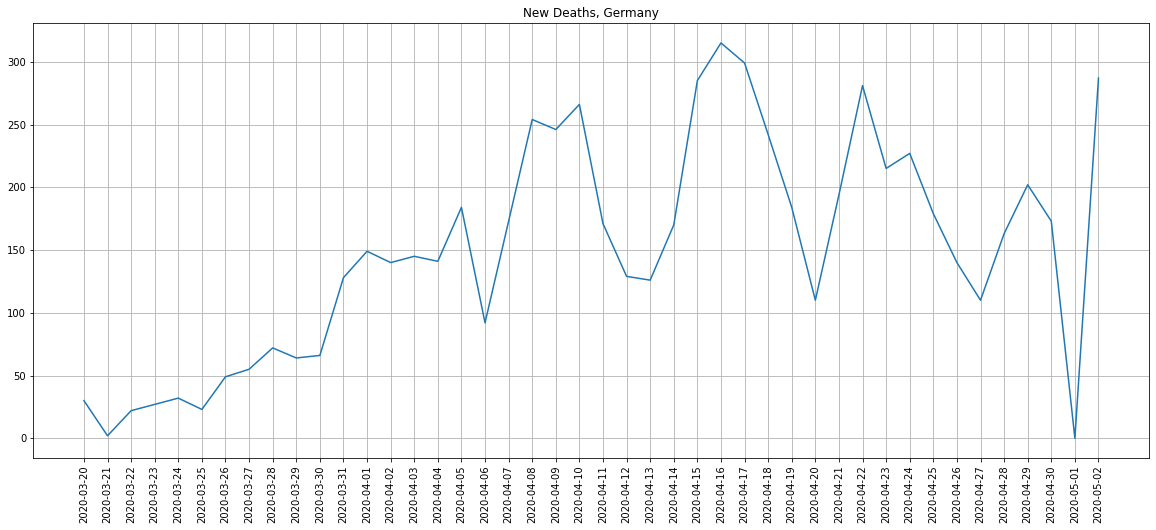

In [12]:
plt.plot(new_deaths_df['2020-03-20':])
plt.xticks(rotation=90)
plt.title("New Deaths, Germany")
plt.grid()

In [0]:
uk_df = time_series_df[time_series_df['location'] == 'United Kingdom']

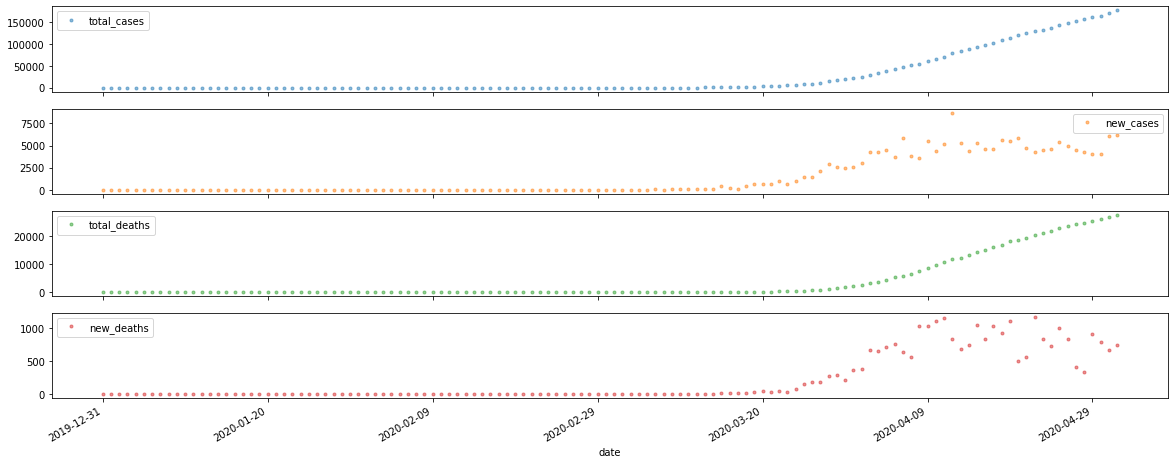

In [14]:
uk_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True);

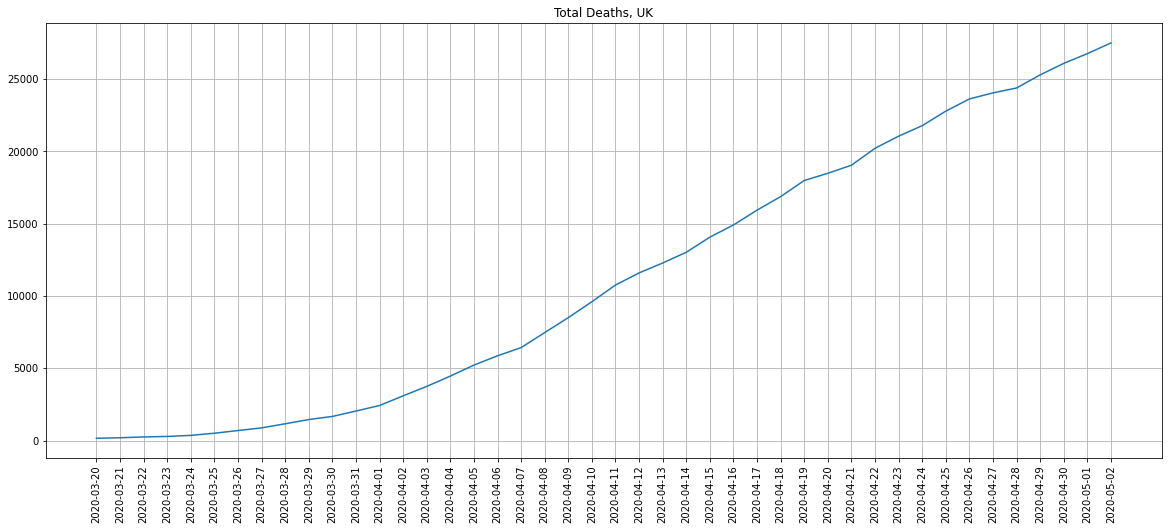

In [15]:
plt.plot(uk_df['total_deaths']['2020-03-20':])
plt.xticks(rotation=90)
plt.title("Total Deaths, UK")
plt.grid()

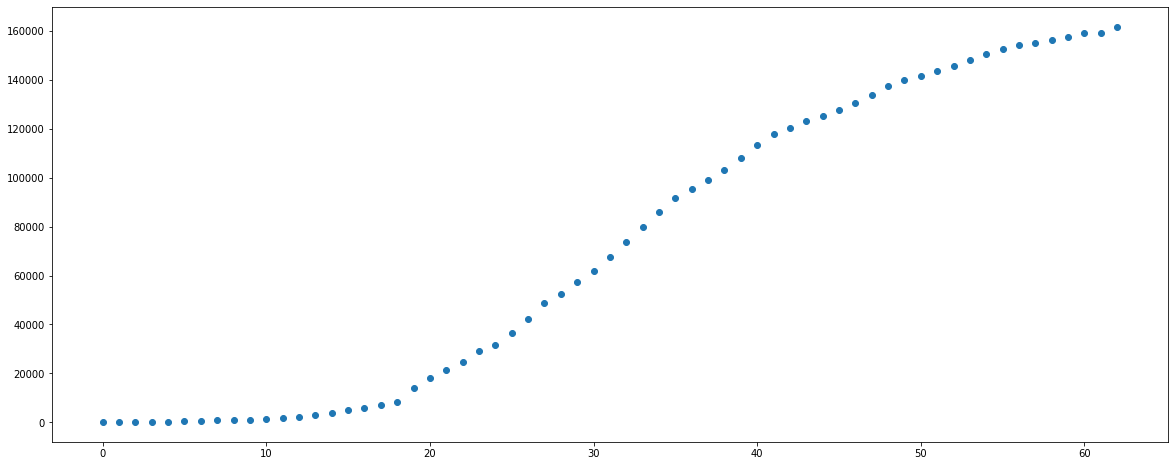

In [16]:
y = total_cases_df['2020-03-01':].values
x = np.arange(0, len(y), 1)
plt.scatter(x, y);

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
tf.random.set_seed(42)

In [0]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [0]:
all_x = x
all_y = y

## Linear Model

In [21]:
start = 0
# end = -1
# start = 20
# end = 40
x = all_x[start:]
y = all_y[start:] / 1000
x.shape, y.shape

((63,), (63,))

In [22]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  # Dense(units=1, input_dim=1, kernel_regularizer=tf.keras.regularizers.l2())                   
  Dense(units=1, input_dim=1)                   
])

model.compile(loss='mae',
            #  optimizer=tf.keras.optimizers.SGD(),
             optimizer=tf.keras.optimizers.Adam(0.1),
            #  optimizer=tf.keras.optimizers.Adam(),
             metrics=[r2_metric]) # we can track the r2 metric over time

history = model.fit(x, y, 
                    batch_size=1,
                    epochs=500,
                    verbose=0)
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(10.514361381530762, 0.6473999619483948)

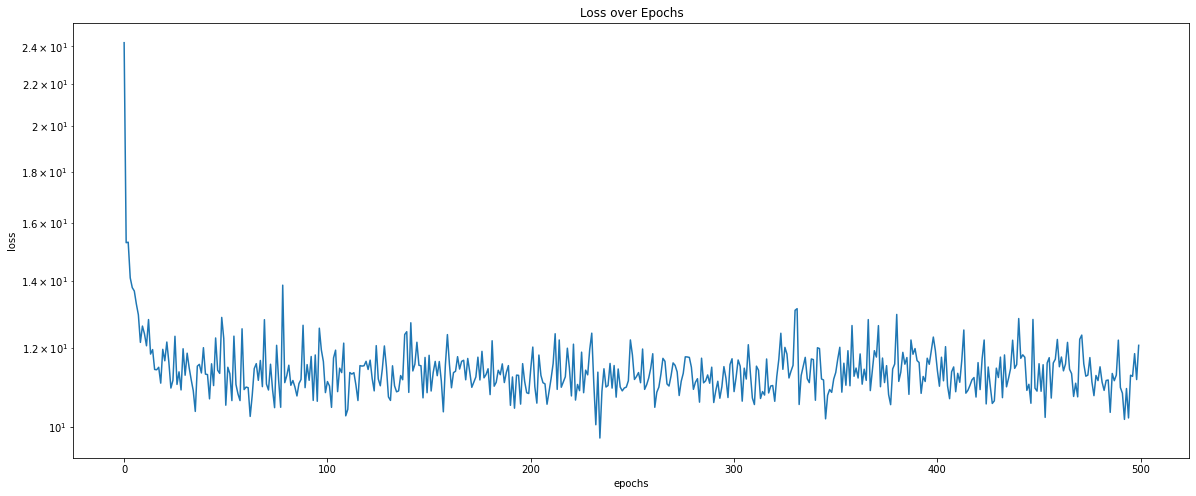

In [23]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

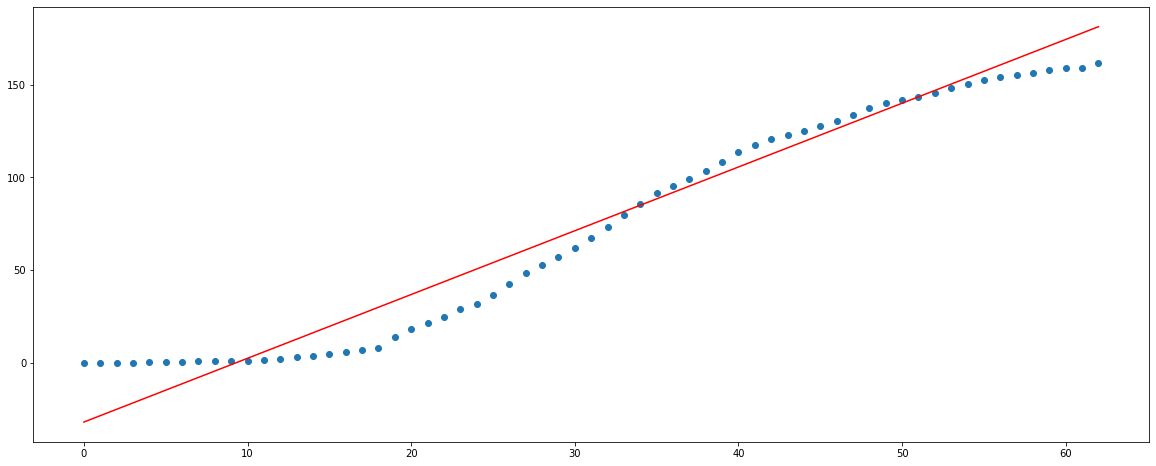

In [24]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
# plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

## S-Curve or completely free model

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

start = 0
# end = -1
x = all_x[start:]
y =  MinMaxScaler().fit_transform(all_y[start:].reshape(-1, 1))
# y =  StandardScaler().fit_transform(all_y[start:].reshape(-1, 1))
# y = all_y[start:] / 1000

x.shape, y.shape

((63,), (63, 1))

In [26]:
y.min(), y.max()

(0.0, 1.0)

In [27]:
from tensorflow.keras.layers import Dense
 
# https://www.tensorflow.org/api_docs/python/tf/keras/activations/exponential
model = tf.keras.Sequential([
  Dense(units=1, activation='linear', input_dim=1),                   
  # Dense(units=5, activation='relu', input_dim=1),                   
  # Dense(units=5, activation='relu'),                   
  # Dense(units=100, activation='relu', input_dim=1),
  # Dense(units=100, activation='relu'),
  # Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='sigmoid'),                   
  # Dense(units=1, activation=tf.keras.activations.exponential),         
  # Dense(units=1, activation='tanh'),                   
  # Dense(units=1, activation='linear')                
])

model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(),
            #  optimizer=tf.keras.optimizers.Adam(0.1),
             metrics=[r2_metric]) # we can track the r2 metric over time

history = model.fit(x, y, 
                    # batch_size=1,
                    epochs=1000,
                    verbose=0)
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.008676341734826565, 0.5182195901870728)

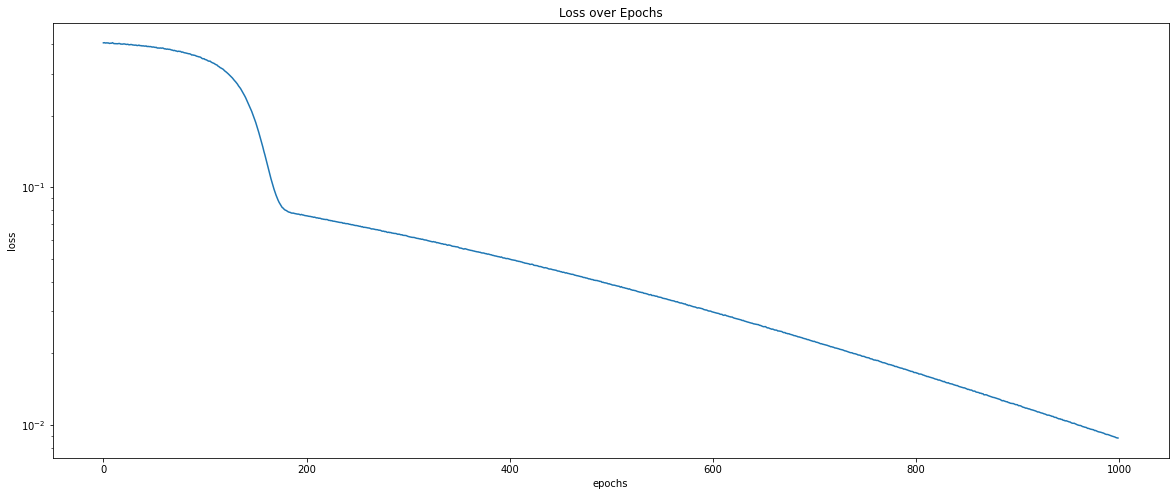

In [28]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

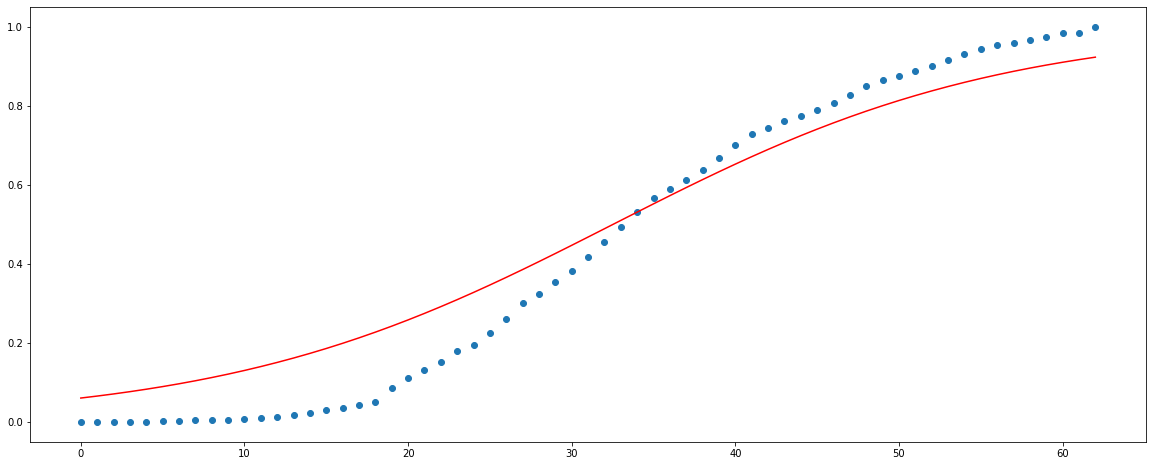

In [29]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
# plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

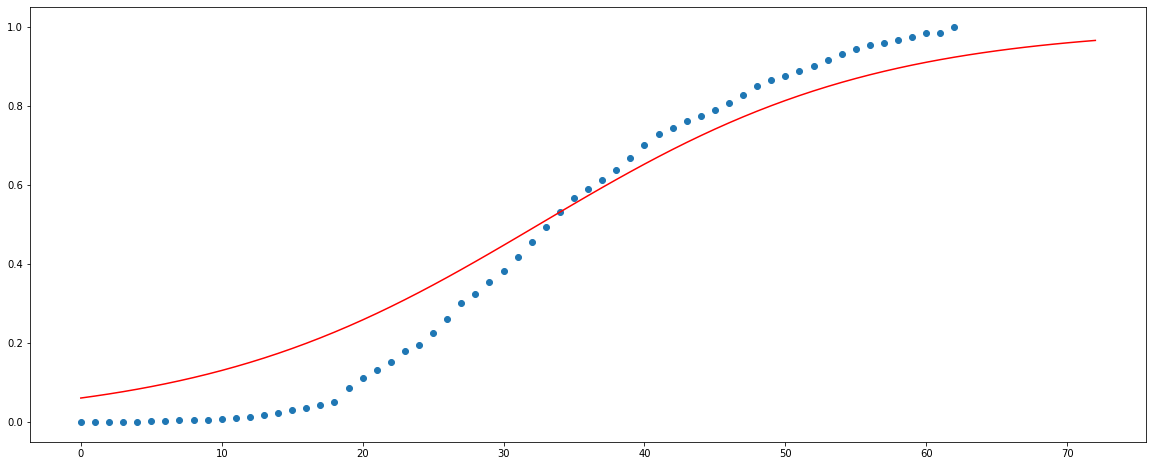

In [30]:
pred_x = np.arange(0, len(y) + 10, 1)
y_pred = model.predict(pred_x)
plt.plot(pred_x, y_pred, color='red')
# plt.scatter(pred_x, y_pred, color='red')
plt.scatter(x, y);